# Gold Price Prediction with the News Sentiment Data 

In [4]:
# importing all the required library
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from scipy.stats import pearsonr


import warnings
warnings.filterwarnings('ignore')

In [49]:
# import the require dataset for the analysis
gold_data = pd.read_csv('result_Data\gold_dataset.csv')
sentiment_data = pd.read_csv('result_Data\sentiment_dataset.csv')

In [50]:
gold_data.head()

,date,gold_price
0,2015-01-02,1186.2
1,2015-01-05,1204.0
2,2015-01-06,1219.4
3,2015-01-07,1210.7
4,2015-01-08,1208.5


In [51]:
gold_data.shape

(2499, 2)

In [52]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        2499 non-null   object 
 1   gold_price  2499 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.2+ KB


In [53]:
sentiment_data.head()

,date,sentiment_score
0,2015-01-02,-0.4019
1,2015-01-05,0.4404
2,2015-01-07,-0.5106
3,2015-01-09,0.0000
4,2015-01-12,0.0000


In [54]:
sentiment_data.shape

(1539, 2)

In [55]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1539 non-null   object 
 1   sentiment_score  1539 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.2+ KB


In [56]:
# function to change the date data type from object to date
def changeDataType(df):
    df['date']=pd.to_datetime(df['date'])
    return df

In [57]:
gold_data = changeDataType(gold_data)
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2499 non-null   datetime64[ns]
 1   gold_price  2499 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.2 KB


In [58]:
sentiment_data = changeDataType(sentiment_data)
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1539 non-null   datetime64[ns]
 1   sentiment_score  1539 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 24.2 KB


In [59]:
# date range in consideration for the analysis
all_dates = pd.date_range(start='2015-01-01', end='2024-10-01', freq='D')

In [60]:
# applying the data range on the sentiment data 
sentiment_data = sentiment_data.set_index('date').reindex(all_dates).rename_axis('date').reset_index()
sentiment_data.head()

,date,sentiment_score
0,2015-01-01,NaN
1,2015-01-02,-0.4019
2,2015-01-03,NaN
3,2015-01-04,NaN
4,2015-01-05,0.4404


In [61]:
sentiment_data.shape

(3562, 2)

In [62]:
# Filter out weekends (Saturday=5, Sunday=6)
sentiment_data = sentiment_data[~sentiment_data['date'].dt.dayofweek.isin([5, 6])]
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2544 entries, 0 to 3561
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2544 non-null   datetime64[ns]
 1   sentiment_score  1222 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 59.6 KB


In [63]:
# combining the sentiment data and the gold data
gold_sentiment = pd.merge(sentiment_data, gold_data, on='date', how='left')
gold_sentiment.shape

(2544, 3)

In [64]:
gold_sentiment.head()

,date,sentiment_score,gold_price
0,2015-01-01,NaN,NaN
1,2015-01-02,-0.4019,1186.2
2,2015-01-05,0.4404,1204.0
3,2015-01-06,NaN,1219.4
4,2015-01-07,-0.5106,1210.7


### Feature Engineering
* Create lag features of the gold price for 1 day and 5 days after the news date

In [66]:
# creating a lag variable for the gold price to create gold price after 1 day and 5 days
gold_sentiment['gold_price_after_1_day'] = gold_sentiment['gold_price'].shift(-1)
gold_sentiment.head()

,date,sentiment_score,gold_price,gold_price_after_1_day
0,2015-01-01,NaN,NaN,1186.2
1,2015-01-02,-0.4019,1186.2,1204.0
2,2015-01-05,0.4404,1204.0,1219.4
3,2015-01-06,NaN,1219.4,1210.7
4,2015-01-07,-0.5106,1210.7,1208.5


In [67]:
gold_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2544 entries, 0 to 2543
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    2544 non-null   datetime64[ns]
 1   sentiment_score         1222 non-null   float64       
 2   gold_price              2499 non-null   float64       
 3   gold_price_after_1_day  2499 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 79.6 KB


In [68]:
gold_sentiment.isnull().sum()

date                         0
sentiment_score           1322
gold_price                  45
gold_price_after_1_day      45
dtype: int64

In [69]:
# reduce to only the date where we have sentiment data and gold data
gold_sentiment.dropna(subset=['sentiment_score','gold_price'], inplace=True)
gold_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1209 entries, 1 to 2543
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    1209 non-null   datetime64[ns]
 1   sentiment_score         1209 non-null   float64       
 2   gold_price              1209 non-null   float64       
 3   gold_price_after_1_day  1185 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 47.2 KB


In [70]:
# filling the null values in Gold_price_after_1_day and Gold_price_after_5_day with interpolation value
gold_sentiment['gold_price_after_1_day'] = gold_sentiment['gold_price_after_1_day'].interpolate()
gold_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1209 entries, 1 to 2543
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    1209 non-null   datetime64[ns]
 1   sentiment_score         1209 non-null   float64       
 2   gold_price              1209 non-null   float64       
 3   gold_price_after_1_day  1209 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 47.2 KB


In [71]:
gold_sentiment.head()

,date,sentiment_score,gold_price,gold_price_after_1_day
1,2015-01-02,-0.4019,1186.2,1204.0
2,2015-01-05,0.4404,1204.0,1219.4
4,2015-01-07,-0.5106,1210.7,1208.5
6,2015-01-09,0.0000,1216.1,1232.8
7,2015-01-12,0.0000,1232.8,1234.4


In [72]:
gold_sentiment.to_csv('result_Data\gold_sentiment.csv', index=False)

## DATA MODEL - To predict gold price after one day of the news headline
Models in consideration:
* Linear Regression model
* Random Forest 
* XGBoost Model
* LSTM

In [74]:
# Load dataset
data = pd.read_csv("result_Data\gold_sentiment.csv")


In [75]:
data.head()

,date,sentiment_score,gold_price,gold_price_after_1_day
0,2015-01-02,-0.4019,1186.2,1204.0
1,2015-01-05,0.4404,1204.0,1219.4
2,2015-01-07,-0.5106,1210.7,1208.5
3,2015-01-09,0.0000,1216.1,1232.8
4,2015-01-12,0.0000,1232.8,1234.4


In [76]:
data.shape

(1209, 4)

In [77]:
# Data preprocessing
# Define features (X) and target variable (y)
X = data.drop(columns=["gold_price_after_1_day",'date'])  
y = data["gold_price_after_1_day"]  

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [78]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}


In [79]:
# Function for hyperparameter tuning with cross-validation
def tune_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, -grid_search.best_score_

# Hyperparameter grids
param_grids = {
    "Linear Regression": {},  # No hyperparameters to tune for plain Linear Regression
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 10]
    }
}


In [80]:
# Train models with cross-validation and hyperparameter tuning
best_models = {}
cv_results = {}

for name, model in models.items():
    print(f"Tuning {name}...")
    param_grid = param_grids.get(name, {})
    best_model, best_cv_score = tune_model(model, param_grid, X_train, y_train)
    best_models[name] = best_model
    cv_results[name] = best_cv_score
    print(f"Best {name} model: {best_model}")
    print(f"Best CV RMSE: {np.sqrt(best_cv_score)}")

# Test the final models on the test set
test_results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    corr, _ = pearsonr(y_test, y_pred)
    test_results[name] = {"RMSE": rmse, "R2": r2 , "corr": corr }
    print(f"{name} Test Results - RMSE: {rmse:.4}, R2: {r2:.4}, Correlation_coef: {corr:.4}")

# Summary of results
print("Cross-Validation Results:")
for name, score in cv_results.items():
    print(f"{name}: {np.sqrt(score)} (RMSE)")

print("\nTest Results:")
for name, results in test_results.items():
    print(f"{name}: RMSE = {results['RMSE']}, R2 = {results['R2']}, Correlation_coef = {results['corr']}")


Tuning Linear Regression...
Best Linear Regression model: LinearRegression()
Best CV RMSE: 15.626741178381822
Tuning Random Forest...
Best Random Forest model: RandomForestRegressor(min_samples_split=10, n_estimators=200, random_state=42)
Best CV RMSE: 17.77901936250908
Tuning XGBoost...
Best XGBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
          

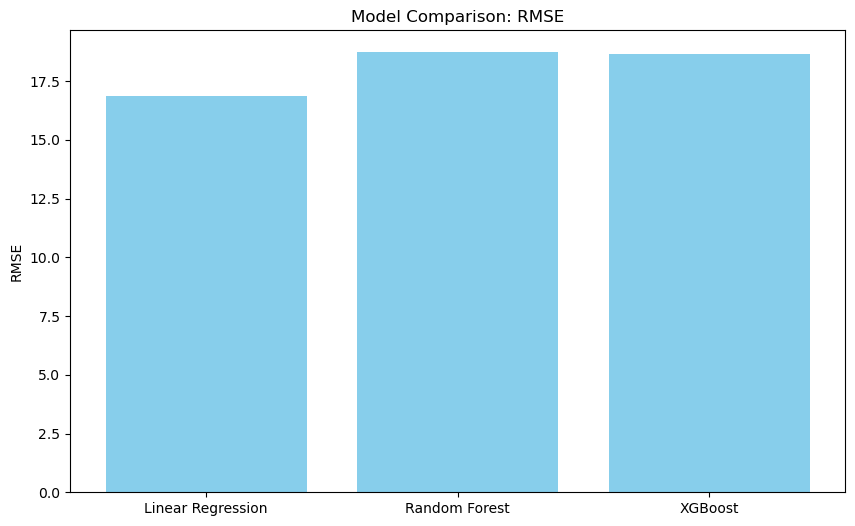

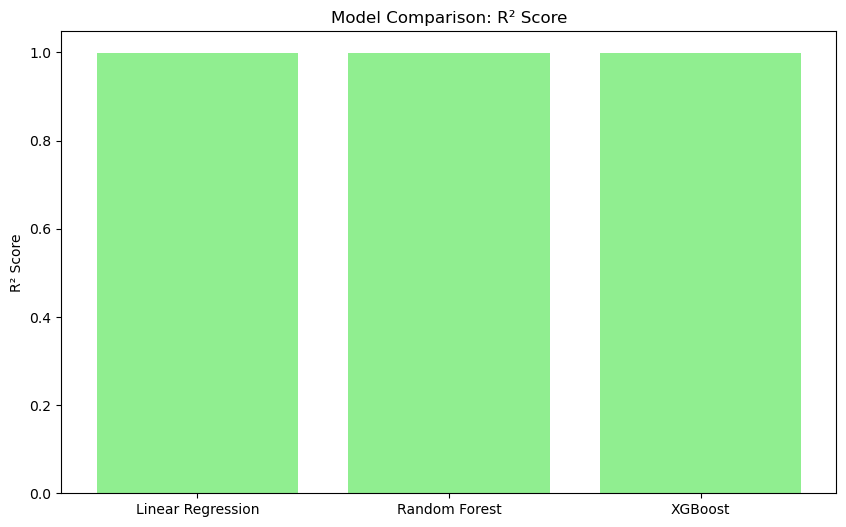

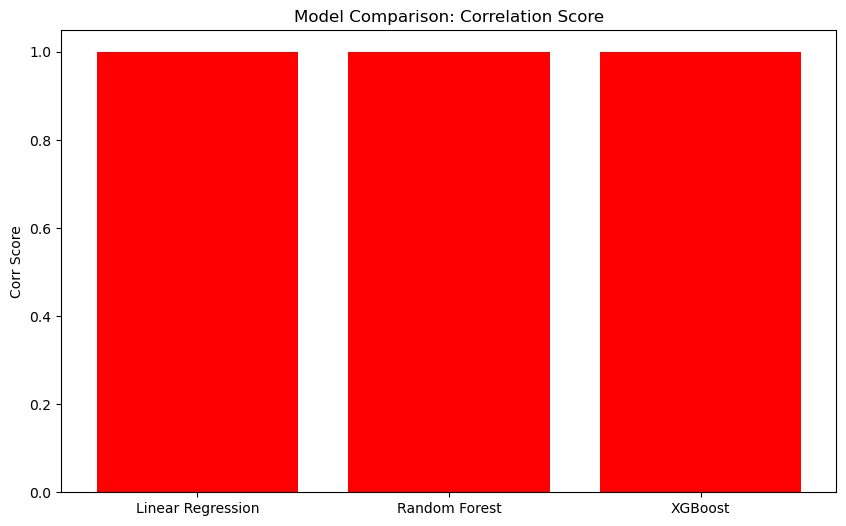

In [81]:
models = list(test_results.keys())
rmse_values = [test_results[model]['RMSE'] for model in models]
r2_values = [test_results[model]['R2'] for model in models]
corr_values = [test_results[model]['corr'] for model in models]

# Plot RMSE
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color='skyblue')
plt.title('Model Comparison: RMSE')
plt.ylabel('RMSE')
plt.show()

# Plot R²
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='lightgreen')
plt.title('Model Comparison: R² Score')
plt.ylabel('R² Score')
plt.show()

# Plot Corr
plt.figure(figsize=(10, 6))
plt.bar(models, corr_values, color='red')
plt.title('Model Comparison: Correlation Score')
plt.ylabel('Corr Score')
plt.show()

### Visualization: 
Ploting the actual gold price against the predicted gold price

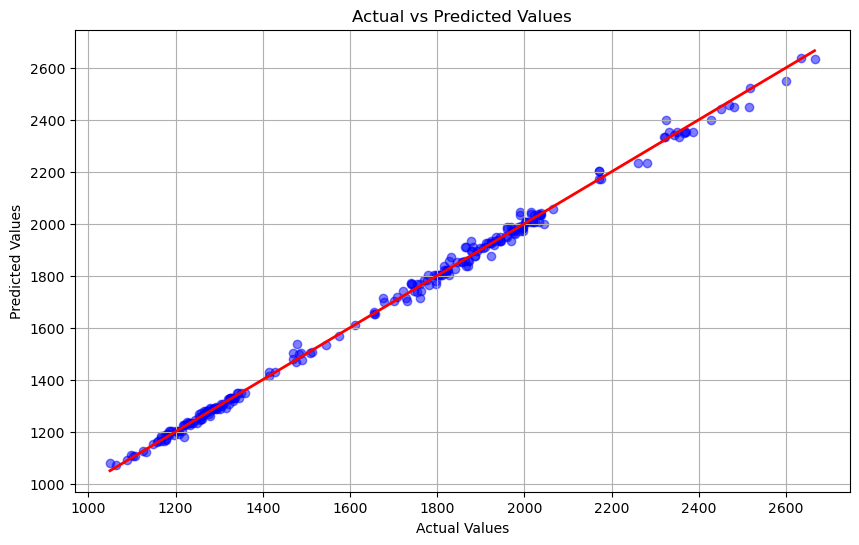

In [83]:
# Create a scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # line of perfect prediction
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


* The red line represents the perfect predictions where the actual and predicted values would be exactly equal. The closer the points are to the red line, the better the predictions.
* From the above visual, there is a close relationship between the predicted value and the actual value

#### Residual Ploting:
* To see how well the model is doing in terms of errors (residuals), below is the plot for the residuals (the difference between the actual and predicted values).
* Residual plot help to visualize any patterns in the residuals, which can indicate model improvement areas. If the residuals are randomly scattered around zero, the model is likely performing well.

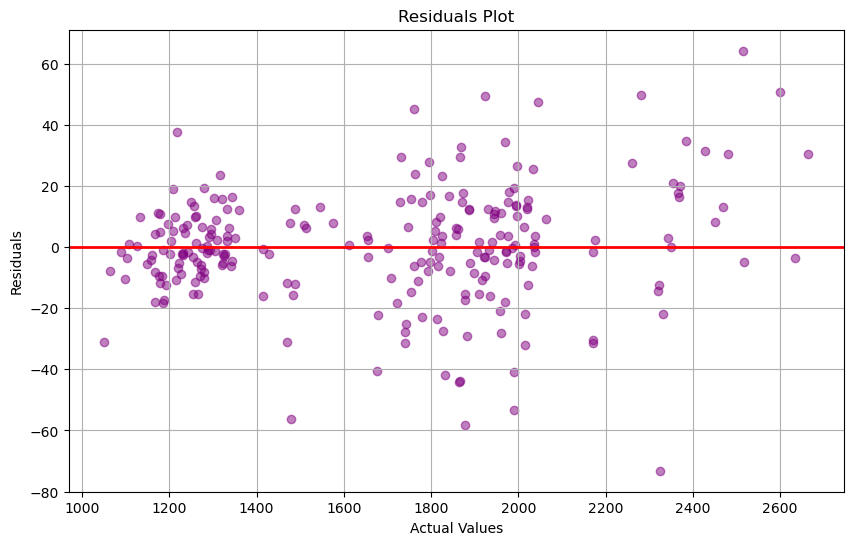

In [86]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='purple', alpha=0.5)
plt.axhline(y=0, color='red', linewidth=2)
plt.title('Residuals Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


### Observation
* From the above residual ploting, we can see that there are still room for improvement for this predictive model
* I will proceed to the next stage and add other economical variables to the fearture and see if it will improve the model performance. 

#### Feature importance


In [89]:
coefficients = best_models['Linear Regression'].coef_
print(coefficients)

[1.14159791e+00 1.63734715e+03]


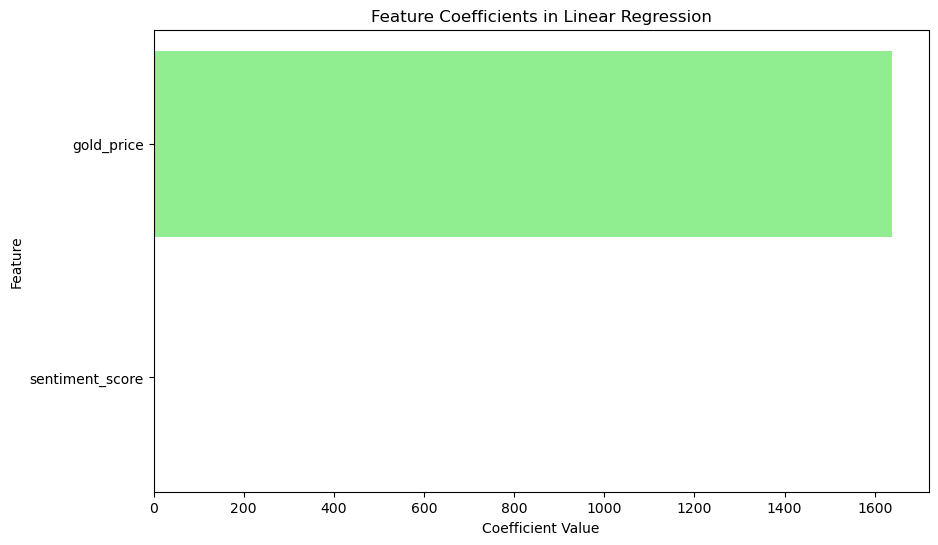

In [90]:
# Get feature coefficients
coefficients = best_models['Linear Regression'].coef_
feature_names = ['sentiment_score', 'gold_price']

# Create a DataFrame to visualize
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance_df['abs_coeff'] = np.abs(importance_df['Coefficient'])  # for better sorting
importance_df = importance_df.sort_values(by='abs_coeff', ascending=False)

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['abs_coeff'], color='lightgreen')
plt.title('Feature Coefficients in Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


### Table view of the actual gold price and the predicted price

In [92]:

# Create a DataFrame to compare actual vs predicted
comparison_df = pd.DataFrame({'Gold Actual Price': y_test, 'Gold Predicted Price': y_pred}) 
comparison_df['diff'] = comparison_df['Gold Predicted Price']-comparison_df['Gold Actual Price']
comparison_df.head(10)

,Gold Actual Price,Gold Predicted Price,diff
101,1049.6,1080.753540,31.153540
432,1483.5,1499.109619,15.609619
309,1332.8,1329.022339,-3.777661
109,1089.1,1090.859131,1.759131
1001,2014.5,2046.369141,31.869141
942,1944.3,1934.715942,-9.584058
231,1253.9,1257.143921,3.243921
49,1186.9,1204.089355,17.189355
785,1876.6,1934.715942,58.115942
746,1801.5,1802.878784,1.378784


In [93]:
price_dif = comparison_df['diff']
print(f'Maximum price diff : {price_dif.max()}')
print(f'the minimum price diff: {price_dif.min()}')
print(f'Average price diff: {price_dif.mean()}')

Maximum price diff : 73.1640625
the minimum price diff: -64.263427734375
Average price diff: -0.2421900221138984
